In [1]:
%load_ext autoreload
%autoreload 1



In [2]:
import pandas as pd
import os
from mimic3benchmarks.mimic3models.preprocessing import Discretizer
import numpy as np
from tqdm import tqdm

dir_path  = '/data1/r10user2/EHR_dataset/mimiciv_benchmark/survival_prediction'

train_path = os.path.join(dir_path , 'train_listfile.csv')
test_path = os.path.join(dir_path , 'test_listfile.csv')

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

x_train = []
del_data = 0
for patient_path in tqdm(train_df['stay']):
    patient_path = os.path.join(dir_path, 'train', patient_path)
    patient = pd.read_csv(patient_path)
    patient = patient.fillna('')
    data_processor = Discretizer(impute_strategy='normal_value', timestep=1)
    data = data_processor.transform(np.array(patient))[0]
    if data.shape[0]  < 48:
        num_pad = 48 - data.shape[0]
        #print(num_pad)
        last_data = data[-1].repeat(num_pad,axis=0).reshape(-1,76)
        #print(last_data.shape)
        data = np.concatenate([data, last_data])

    if data.shape[0] == 48:
        x_train.append(data)
    else:
        del_data += 1
       
print(del_data) 
    

ModuleNotFoundError: No module named 'mimic3benchmarks'

In [ ]:
x_train = np.array(x_train)
t_train = np.array(train_df['survival_time'])
e_train = np.array(train_df['censor'])
np.save("x_train.npy", x_train)
np.save("t_train.npy", t_train)
np.save("e_train.npy", e_train)

In [ ]:
t_train

array([ 47.38      , 119.7       ,  22.63472222, ...,  48.59055556,
        32.99166667,  16.94916667])

In [ ]:
x_test = []
del_data = 0
for patient_path in tqdm(test_df['stay']):
    patient_path = os.path.join(dir_path, 'test', patient_path)
    patient = pd.read_csv(patient_path)
    patient = patient.fillna('')
    data_processor = Discretizer(impute_strategy='normal_value',timestep=1)
    data = data_processor.transform(np.array(patient))[0]
    if data.shape[0]  < 48:
        num_pad = 48 - data.shape[0]
        #print(num_pad)
        last_data = data[-1].repeat(num_pad,axis=0).reshape(-1,76)
        #print(last_data.shape)
        data = np.concatenate([data, last_data])

    if data.shape[0] == 48:
        x_test.append(data)
    else:
        del_data += 1
       
print(del_data) 

100%|██████████| 4972/4972 [00:40<00:00, 122.89it/s]

0


In [ ]:
x_test = np.array(x_test)
t_test = np.array(test_df['survival_time'])
e_test = np.array(test_df['censor'])
np.save("x_test.npy", x_test)
np.save("t_test.npy", t_test)
np.save("e_test.npy", e_test)

In [ ]:
print(x_train.shape)
print(t_train.shape)

(18064, 48, 76)
(18064,)


In [ ]:
import numpy as np
x_train = np.load('x_train.npy')
t_train = np.load('t_train.npy')
e_train = 1 - np.load('e_train.npy')

In [ ]:
index = np.where(t_train <= 0)[0]
len(index)

103

In [ ]:
t_train = np.delete(t_train, index)
e_train = np.delete(e_train, index)
x_train = np.delete(x_train, index, axis=0)
print(x_train.shape)

(17961, 48, 76)


In [ ]:
print(e_train.sum()/len(e_train))

0.11747675519180446


In [ ]:
np.where(t_train <= 0)

(array([], dtype=int64),)

In [ ]:
models = []

from auton_survival.models.dsm import DeepRecurrentSurvivalMachines
from auton_survival.models.dsm import DeepSurvivalMachines

# model = DeepRecurrentSurvivalMachines(k=3,
#                distribution='LogNormal',
#                layers=10)
model = DeepSurvivalMachines(
    k=1,
    distribution="LogNormal",
    layers=[100]
)
# The fit method is called to train the model
model.fit(x_train, t_train, e_train, iters=100, learning_rate=1e-4)








/home/r10user10/Documents/anaconda3/envs/python310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (48) must match the size of tensor b (100) at non-singleton dimension 1

In [ ]:
trained_weights = model.trained_weights
print(trained_weights.shape)
print(np.isnan(trained_weights).sum())

(24, 15267, 1)
0


In [ ]:
import numpy as np
x_test = np.load('x_test.npy')
t_test = np.load('t_test.npy')
e_test = 1 - np.load('e_test.npy')
x_test.shape

(4972, 48, 76)

In [ ]:
t = np.concatenate((t_test , t_train),axis=0)
e = np.concatenate((e_test , e_train),axis=0)
x = np.concatenate((x_test , x_train),axis=0)
x.shape

(22933, 48, 76)

In [ ]:
horizons = [0.25, 0.5, 0.75, 0.9]
times = np.quantile(t[e == 1], horizons).tolist()
# print(times)
out_risk = model.predict_risk(x_test, times)
print(out_risk.shape)
out_survival = model.predict_survival(x_test, times)
# print(out_survival[0])
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc

cis = []
brs = []

et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))],
                 dtype = [('e', bool), ('t', float)])
# print(et_train)
et_test = np.array([(e_test[i], t_test[i]) for i in range(len(e_test))],
                 dtype = [('e', bool), ('t', float)])
# et_val = np.array([(e_val[i], t_val[i]) for i in range(len(e_val))],
#                  dtype = [('e', bool), ('t', float)])
# print(et_train[0:10])
for i, _ in enumerate(times):
    cis.append(concordance_index_ipcw(et_train, et_test, out_risk[:, i], times[i])[0])
brs.append(brier_score(et_train, et_test, out_survival, times)[1])
roc_auc = []
for i, _ in enumerate(times):
    roc_auc.append(cumulative_dynamic_auc(et_train, et_test, out_risk[:, i], times[i])[0])
for horizon in enumerate(horizons):
    print(f"For {horizon[1]} quantile")
    print("TD Concordance Index:", cis[horizon[0]])
    print("Brier Score:", brs[0][horizon[0]])
    print("ROC AUC ", roc_auc[horizon[0]][0], "\n")

(4972, 4)
For 0.25 quantile
TD Concordance Index: 0.7501109140105855
Brier Score: 0.04374365045897336
ROC AUC  0.7275706406956468 

For 0.5 quantile
TD Concordance Index: 0.6942621255117725
Brier Score: 0.10662817214287049
ROC AUC  0.6505921963917142 

For 0.75 quantile
TD Concordance Index: 0.6499962178672913
Brier Score: 0.20011246862156407
ROC AUC  0.6061074770174052 

For 0.9 quantile
TD Concordance Index: 0.6170279008490849
Brier Score: 0.24163905949422967
ROC AUC  0.5784667048214809 



IndexError: index 97 is out of bounds for axis 0 with size 24

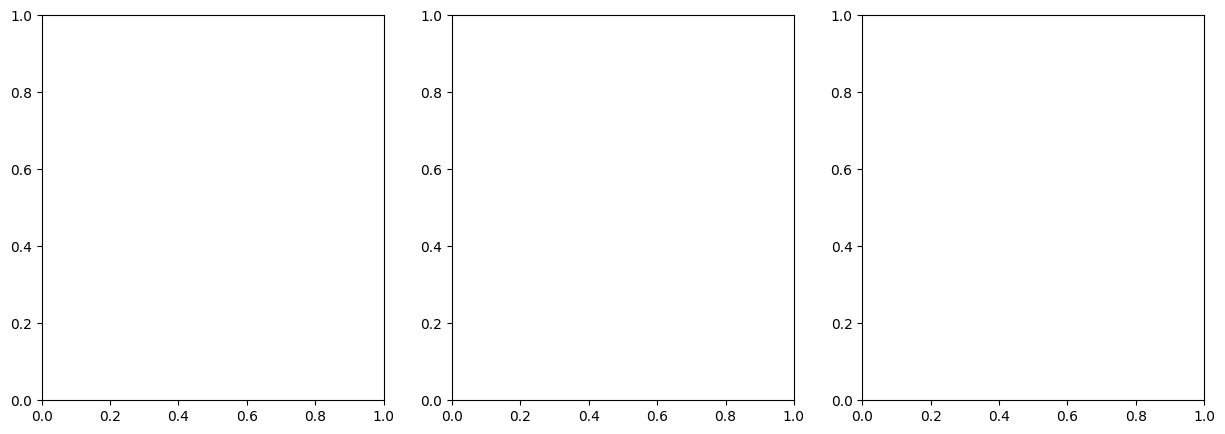

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

figs, axes = plt.subplots(1, 3, figsize=(15, 5))
iter_idx = [97, 98, 99]

for idx in range(3):
    sns.kdeplot(trained_weights[iter_idx[idx]][:, 0], fill=True, ax=axes[idx])
    sns.kdeplot(trained_weights[iter_idx[idx]][:, 1], fill=True, ax=axes[idx])
    sns.kdeplot(trained_weights[iter_idx[idx]][:, 2], fill=True, ax=axes[idx])
    sns.kdeplot(trained_weights[iter_idx[idx]][:, 3], fill=True, ax=axes[idx])
    axes[idx].set_title(f'Iter {iter_idx[idx]}')
    axes[idx].set_xlim(0.15, 0.4)

In [ ]:
from sksurv.datasets import load_whas500
X, y = load_whas500()
y

array([(False, 2.178e+03), (False, 2.172e+03), (False, 2.190e+03),
       ( True, 2.970e+02), (False, 2.131e+03), ( True, 1.000e+00),
       (False, 2.122e+03), ( True, 1.496e+03), ( True, 9.200e+02),
       (False, 2.175e+03), (False, 2.173e+03), ( True, 1.671e+03),
       (False, 2.192e+03), ( True, 8.650e+02), (False, 2.166e+03),
       (False, 2.168e+03), ( True, 9.050e+02), ( True, 2.353e+03),
       (False, 2.146e+03), ( True, 6.100e+01), ( True, 2.358e+03),
       (False, 2.114e+03), (False, 2.132e+03), (False, 2.139e+03),
       (False, 2.048e+03), (False, 2.152e+03), ( True, 6.000e+00),
       (False, 2.156e+03), ( True, 1.180e+02), (False, 2.064e+03),
       ( True, 8.490e+02), ( True, 7.140e+02), (False, 2.057e+03),
       ( True, 2.000e+00), ( True, 7.000e+00), (False, 2.151e+03),
       ( True, 6.000e+00), ( True, 4.220e+02), ( True, 3.540e+02),
       (False, 2.065e+03), (False, 2.048e+03), ( True, 1.065e+03),
       ( True, 5.350e+02), (False, 2.118e+03), ( True, 9.700e+

In [ ]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
x_train_avg = np.mean(x_train, axis=1)
x_test_avg = np.mean(x_test, axis=1)
print(x_train_avg.shape)
cph = CoxPHSurvivalAnalysis()
cph.fit(x_train_avg, et_train)
pre = cph.predict(x_test_avg)
concordance_index_ipcw(et_train, et_test, pre)[0]

(17961, 76)


/home/r10user10/Documents/anaconda3/envs/python310/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:173: RuntimeWarning: overflow encountered in exp
  risk_set += np.exp(xw[k])
/home/r10user10/Documents/anaconda3/envs/python310/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:170: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])
/home/r10user10/Documents/anaconda3/envs/python310/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=6.8628e-17): result may not be accurate.
  delta = solve(
/home/r10user10/Documents/anaconda3/envs/python310/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=2.30423e-17): result may not be accurate.
  delta = solve(
/home/r10user10/Documents/anaconda3/envs/python310/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=1.67848e-17): result may not be a

0.6303095634116432

In [ ]:
from auton_survival import DeepCoxPH
x_train_avg = np.mean(x_train, axis=1)

model = DeepCoxPH(layers=[100])
model.fit(x_train_avg, t_train, e_train, iters=100, learning_rate=1e-4)

 79%|███████▉  | 79/100 [00:17<00:04,  4.56it/s]


In [ ]:
x_test_avg = np.mean(x_test, axis=1)

In [ ]:
horizons = [0.25, 0.5, 0.75, 0.9]
times = np.quantile(t[e == 1], horizons).tolist()
print(times)
out_risk = model.predict_risk(x_test_avg, times)
print(np.isnan(out_risk).sum())
out_survival = model.predict_survival(x_test_avg, times)
# print(out_survival[0])
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc

cis = []
brs = []

et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))],
                 dtype = [('e', bool), ('t', float)])
print(et_train)
et_test = np.array([(e_test[i], t_test[i]) for i in range(len(e_test))],
                 dtype = [('e', bool), ('t', float)])
# et_val = np.array([(e_val[i], t_val[i]) for i in range(len(e_val))],
#                  dtype = [('e', bool), ('t', float)])
# print(et_train[0:10])
for i, _ in enumerate(times):
    cis.append(concordance_index_ipcw(et_train, et_test, out_risk[:, i], times[i])[0])
brs.append(brier_score(et_train, et_test, out_survival, times)[1])
roc_auc = []
for i, _ in enumerate(times):
    roc_auc.append(cumulative_dynamic_auc(et_train, et_test, out_risk[:, i], times[i])[0])
for horizon in enumerate(horizons):
    print(f"For {horizon[1]} quantile")
    print("TD Concordance Index:", cis[horizon[0]])
    print("Brier Score:", brs[0][horizon[0]])
    print("ROC AUC ", roc_auc[horizon[0]][0], "\n")

[41.58041666666668, 104.88333333333333, 219.08069444444445, 382.98422222222223]
0
[(False,  47.38      ) ( True, 119.7       ) (False,  22.63472222) ...
 ( True,  48.59055556) (False,  32.99166667) (False,  16.94916667)]
For 0.25 quantile
TD Concordance Index: 0.7577670480027097
Brier Score: 0.043953331859146245
ROC AUC  0.7360779703436262 

For 0.5 quantile
TD Concordance Index: 0.6983169711107678
Brier Score: 0.10701804934126019
ROC AUC  0.6528685099318772 

For 0.75 quantile
TD Concordance Index: 0.6466879811005131
Brier Score: 0.20727602640918452
ROC AUC  0.5946807399830735 

For 0.9 quantile
TD Concordance Index: 0.6280973480587356
Brier Score: 0.24071580478966462
ROC AUC  0.6026205003987266 



In [3]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/r10user10/Documents/Jiacheng/dspm-auton-survival')

from nfm.nfm.datasets import SurvivalDataset
from nfm.nfm.base import FullyNeuralNLL
from nfm.nfm.eps_config import ParetoEps
from pycox.evaluation.eval_surv import EvalSurv

import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features=1 + data_full.num_features, out_features=128, bias=False),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=1, bias=False)
        )

    def forward(self, y, z):
        inputs = torch.cat([z, y], dim=1)
        return torch.exp(self.mlp(inputs))


data_full = SurvivalDataset.metabric('/home/r10user10/Documents/Jiacheng/dspm-auton-survival/nfm/data/metabric_IHC4_clinical_train_test.h5')
fold_c_indices = []
fold_ibs = []
fold_nbll = []
normalizing_factor = 366.25


def normalize(y):
    return (y + 1) / normalizing_factor




/home/r10user10/Documents/anaconda3/envs/python310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
for i in range(len(data_full)):
    if not data_full[i][0].is_cuda:
        print('error')
    if not data_full[i][1].is_cuda:
        print('error')
    if not data_full[i][2].is_cuda:
        print('error')

In [5]:
for j in tqdm(range(10)):
    torch.manual_seed(77+j)
    train_folds, valid_folds, test_folds = data_full.cv_split(shuffle=True)
    for i in range(5):
        test_c_indices, test_ibs, test_nbll = [], [], []
        valid_losses = []
        nll = FullyNeuralNLL(eps_conf=ParetoEps(learnable=True), encoder=Net()).cuda()
        optimizer = torch.optim.Adam(lr=1e-2, weight_decay=1e-3, params=nll.parameters())
        loader = DataLoader(train_folds[i], batch_size=128)
        for epoch in range(50):
            for z, y, delta in loader:
                nll.train()
                loss = nll(z=z, y=normalize(y), delta=delta)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            nll.eval()
            with torch.no_grad():
                y_valid, delta_valid, z_valid = valid_folds[i].sort()
                y_test, delta_test, z_test = test_folds[i].sort()
                y_valid, y_test = normalize(y_valid), normalize(y_test)
                valid_loss = nll(z_valid, y_valid, delta_valid)
                valid_losses.append(valid_loss)
                tg_test = np.linspace(y_test.cpu().numpy().min(), y_test.cpu().numpy().max(), 100)
                tg_test = torch.tensor(tg_test, dtype=torch.float).view(-1, 1).cuda()
                surv_pred_test = nll.get_survival_prediction(
                    z_test=z_test, y_test=tg_test)

                test_evaluator = EvalSurv(
                    surv=pd.DataFrame(surv_pred_test.cpu().numpy(), index=tg_test.reshape(-1).cpu().numpy()),
                    durations=y_test.cpu().numpy().reshape(-1),
                    events=delta_test.cpu().numpy().reshape(-1),
                    censor_surv='km')
                test_c_indices.append(test_evaluator.concordance_td(method='antolini'))
                test_ibs.append(test_evaluator.integrated_brier_score(time_grid=tg_test.cpu().numpy()))
                test_nbll.append(test_evaluator.integrated_nbll(time_grid=tg_test.cpu().numpy()))
        valid_argmin = np.argmin(valid_losses)
        fold_c_indices.append(np.asarray(test_c_indices)[valid_argmin])
        fold_ibs.append(np.asarray(test_ibs)[valid_argmin])
        fold_nbll.append(np.asarray(test_nbll)[valid_argmin])


report_str = f"""
Results:
    mean c-index: {np.asarray(fold_c_indices).mean()}
    std c-index: {np.asarray(fold_c_indices).std()}
    mean ibs: {np.asarray(fold_ibs).mean()}
    std ibs: {np.asarray(fold_ibs).std()}
    mean ibll: {np.asarray(fold_nbll).mean()}
    std ibll: {np.asarray(fold_nbll).std()}
"""
print(report_str)

  0%|          | 0/10 [00:00<?, ?it/s]

/home/r10user10/Documents/Jiacheng/dspm-auton-survival/nfm/nfm/datasets.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float, device=default_device).view(-1, 1)
/home/r10user10/Documents/Jiacheng/dspm-auton-survival/nfm/nfm/datasets.py:191: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.delta = torch.tensor(delta, dtype=torch.float, device=default_device).view(-1, 1)
/home/r10user10/Documents/Jiacheng/dspm-auton-survival/nfm/nfm/datasets.py:192: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function max>) found for signature:
 
 >>> max(array(float64, 1d, C), float64)
 
There are 8 candidate implementations:
  - Of which 6 did not match due to:
  Overload of function 'max': File: <numerous>: Line N/A.
    With argument(s): '(array(float64, 1d, C), float64)':
   No match.
  - Of which 2 did not match due to:
  Overload in function 'iterable_max': File: numba/cpython/builtins.py: Line 648.
    With argument(s): '(array(float64, 1d, C), float64)':
   Rejected as the implementation raised a specific error:
     TypingError: too many positional arguments
  raised from /home/r10user10/Documents/anaconda3/envs/python310/lib/python3.10/site-packages/numba/core/typing/templates.py:784

During: resolving callee type: Function(<built-in function max>)
During: typing of call at /home/r10user10/Documents/anaconda3/envs/python310/lib/python3.10/site-packages/pycox/evaluation/ipcw.py (18)


File "../../../anaconda3/envs/python310/lib/python3.10/site-packages/pycox/evaluation/ipcw.py", line 18:
    def _inv_cens_score_single(func, ts, durations, events, surv, censor_surv, idx_ts_surv_i,
        <source elided>
            g_tt = censor_surv[idx_tt_censor[i], i]
            g_ts = max(g_ts, min_g)
            ^
